In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Rocket import Rocket
from Dynamics import Dynamics
from Plot3D import Plot3D


import time
import pylab as pl
from IPython import display

np.set_printoptions(precision=3,suppress=True)

Dynamics of the rocket

$m \, \ddot{x} = F_x$

$m \, \ddot{z} = -m\,g + T\,\cos{\alpha}$

$ I_y \, \ddot{\theta_y} = T\,l_t\,\sin{\alpha}$

Control inputs $T$ and $\alpha$

$\begin{bmatrix}F_x \\ F_z\end{bmatrix}$ = $rot(\theta _y)\begin{bmatrix}T\,\sin{\alpha} \\ T\,\cos{\alpha}\end{bmatrix}$


In [2]:
#https://www.spacex.com/vehicles/falcon-9/

falcon = Rocket("Falcon 9")
falcon.mass = 549054 #kg
falcon.height = 70 #m
falcon.radius = 3.7/2 #m
falcon.max_thrust = 7607e3 #N
falcon.cg_thrust_length = 20 #m
falcon.cg_cp_length = 15 #m
falcon.Cd = 10000.82

falcon.load()
dynamics = Dynamics(falcon)

In [3]:
falcon2 = Rocket("Falcon 9")
falcon2.mass = 549054 #kg
falcon2.height = 70 #m
falcon2.radius = 3.7/2 #m
falcon2.max_thrust = 7607e3 #N
falcon2.cg_thrust_length = 20 #m
falcon2.cg_cp_length = 15 #m
falcon2.Cd = 10000.82
falcon2.load()
dynamics2 = Dynamics(falcon2)

i, 0
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [ 0.068  0.    -0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.           0.   ]
Cross [0 0 0]
dW [0.068 0.    0.   ]
M [15188656.009        0.       

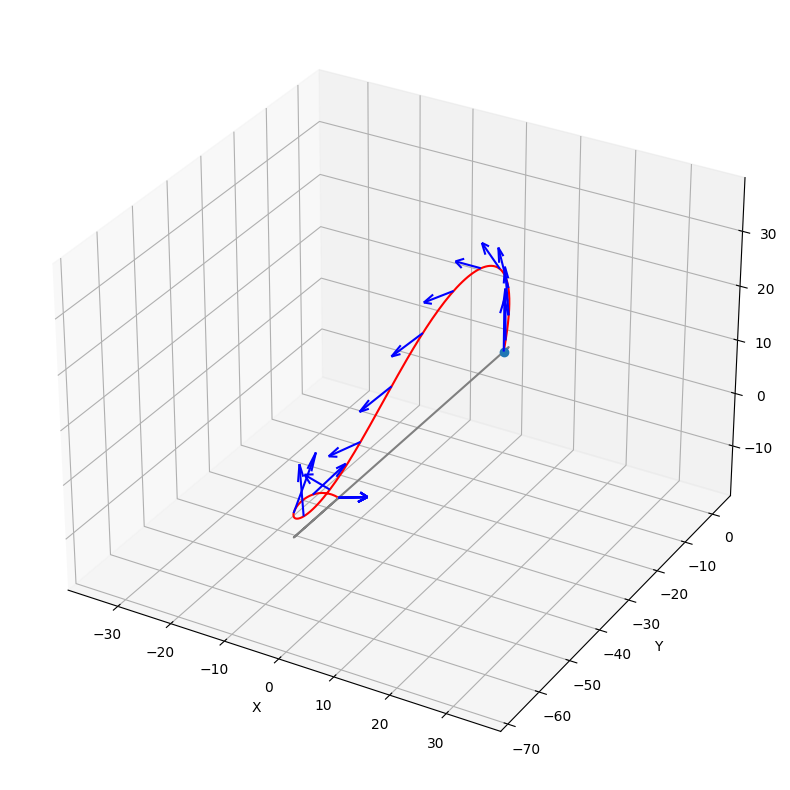

In [4]:
falcon.input(1,0.1,1*np.pi/2)

for i in range(200):
    print("i,",i)
    dynamics.update(0.1)

plot3d = Plot3D(falcon, dynamics.states)
plot3d.set(10,10)
plot3d.plot()
plot3d.attitude()
plot3d.origin()

i, 0
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009        0.   ]
Cross [0 0 0]
dW [0.    0.068 0.   ]
M [       0.    15188656.009       

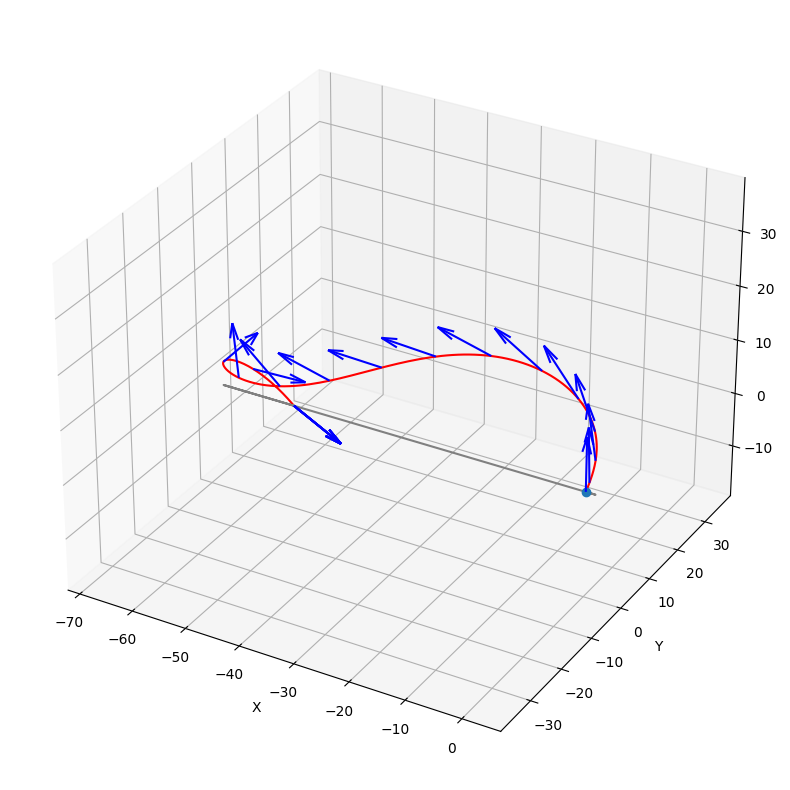

In [5]:
falcon2.input(1,0.1,0)

for i in range(200):
    print("i,",i)
    dynamics2.update(0.1)

plot3d = Plot3D(falcon2, dynamics2.states)
plot3d.set(10,10)
plot3d.plot()
plot3d.attitude()
plot3d.origin()

In [6]:
dynamics.state

array([  -0.   ,  -53.695,   -0.   ,    0.   ,    7.142,  -10.676,
          0.   ,    0.   , -408.456,  248.791,    2.069,    0.   ,
         -0.   ])

In [7]:
dynamics2.state

array([-53.695,   0.   ,  -0.   ,   7.142,   0.   , -10.676,   0.   ,
       408.456,   0.   , 248.791,   0.   ,   2.069,   0.   ])